# 6year test run
# How different is the length of the trajectories in the daily vs. 10-daily data set?

# Fig. 5 in GMD paper

In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import seawater
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import random
from numba import njit
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm


In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/trajectory_daily_vs_10daily/6year_run/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [3]:
####
# specifics for trajectory output
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()



236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)


In [4]:
#----
# load daily float output from E3SM: oxygen, nitrate
#----
# NOTE: the reduction to "deep" floats is not 100% exact.
#  -> when running this over different years, a different number of floats is identified as "shallow" floats
#  -> for now, I kick out those that are "shallow" on day 1 of year 1
# How to treat this later?

path = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'
year_list = ['0055','0056','0057','0058','0059','0060']

# kick out floats in shallow regions (these are not correctly advected)
ind = np.where(zlevs<=2200)[0]

for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    file1 = 'floats.year'+year_list[yy]+'.nc'   
    data = xr. open_dataset(path+file1)

    lon_1   = data['particleColumnLon'].values*rad_to_deg 
    lat_1   = data['particleColumnLat'].values*rad_to_deg 
    oxy_1   = data['particleColumnO2'].values #[:,0,:]
    #no3_1   = data['particleColumnNO3'].values
    #print('lat_all',lat_all.shape)

    # set missing values to NaN (deep ocean layers) 
    lat_1[oxy_1==-1]=np.nan
    lon_1[oxy_1==-1]=np.nan
    lat_1[lat_1==0]=np.nan
    lon_1[lon_1==0]=np.nan
    #no3_1[oxy_1==-1]=np.nan 
    #oxy_1[oxy_1==-1]=np.nan 
    
    print('Reduce to floats in the deep ocean')
    if yy==0: # only load the first time, re-use ind_deep
        aux = np.sum(np.isnan(lat_1[0,ind,:]),axis=0) # check if any of the depth levels shallower than 1100m is NaN
        ind_deep = np.where(aux==0)[0] # if it is, aux is >0; only keep those that are 0
  #  #print('Floats in the deep ocean:',ind_deep.shape)
    lon_1   = lon_1[:,:,ind_deep]
    lat_1   = lat_1[:,:,ind_deep]
    #no3_1   = no3_1[:,:,ind_deep]
    #oxy_1   = oxy_1[:,:,ind_deep]
    
    if yy==0: # first time
        lat_all = lat_1[:,0,:]
        lon_all = lon_1[:,0,:]
        #no3_all_E3SM   = no3_1
        #oxy_all_E3SM   = oxy_1
    else:
        lat_all = np.concatenate((lat_all,lat_1[:,0,:]))
        lon_all = np.concatenate((lon_all,lon_1[:,0,:]))
        #no3_all_E3SM = np.concatenate((no3_all_E3SM,no3_1))
        #oxy_all_E3SM = np.concatenate((oxy_all_E3SM,oxy_1))
        
    del lon_1,lat_1,oxy_1
    print(lon_all.shape)
    
print ('done')


Load year 0055
Reduce to floats in the deep ocean
(364, 8647)
Load year 0056
Reduce to floats in the deep ocean
(728, 8647)
Load year 0057
Reduce to floats in the deep ocean
(1092, 8647)
Load year 0058
Reduce to floats in the deep ocean
(1456, 8647)
Load year 0059
Reduce to floats in the deep ocean
(1819, 8647)
Load year 0060
Reduce to floats in the deep ocean
(2183, 8647)
done


In [6]:
#---
# get 10-daily sampling positions
#---

n_freq = 10

lon_all_10 = lon_all[0::n_freq,:]
lat_all_10 = lat_all[0::n_freq,:]

print(lon_all.shape)
print(lon_all_10.shape)


(2183, 8647)
(219, 8647)


In [7]:
#-----
# How far has each float travelled (horizontally) in those xx months?
#-----

#-------
# functions
#-------

@njit
def get_closest_grid_point(lon_point, lat_point, lon2, lat2):  
    # in all nodes in mesh, return the index of the closest node to lon_point/lat_point
    # lon2 & lat2 are the locations in the new mesh (to be redistributed to)
    # lon2 & lat2 should be in radians
    # numpy needs to be imported outside the function
    
    #from math import sin, cos, sqrt, atan2, radians
    #import numpy as np
    # approximate radius of earth in km
    R = 6373.0
    
    #lat2 = radians(mesh.y2) # all positions in mesh
    #lon2 = radians(mesh.x2)
    #lat2 = [radians(x) for x in mesh.y2]
    #lon2 = [radians(x) for x in mesh.x2]
    lat1 = radians(lat_point)
    lon1 = radians(lon_point)
    bb1 = cos(lat1)
    
    all_distances = np.zeros(len(lon2))
    for i in range(0,len(lon2)):
        dlon = lon2[i] - lon1
        dlat = lat2[i] - lat1
        a = sin(dlat / 2)**2 + bb1 * cos(lat2[i]) * sin(dlon / 2)**2
        all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # to speed things up, omit constant factors here!
        #all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # correct distance
        #del dlon, dlat, a
    index_closest_node = np.argmin(all_distances)
    distance_closest_node = np.min(all_distances)

    return index_closest_node, distance_closest_node

@njit
def get_closest_grid_point_vector(lon_point, lat_point, lon2, lat2):  
    # PROVIDE LIST OF LOCATIONS TO FUNCTION!
    # in all nodes in mesh, return the index of the closest node to lon_point/lat_point
    # lon2 & lat2 are the locations in the new mesh (to be redistributed to)
    # lon2 & lat2 should be in radians
    # numpy needs to be imported outside the function
    
    #from math import sin, cos, sqrt, atan2, radians
    #import numpy as np
    # approximate radius of earth in km
    R = 6373.0
    
    #lat2 = radians(mesh.y2) # all positions in mesh
    #lon2 = radians(mesh.x2)
    #lat2 = [radians(x) for x in mesh.y2]
    #lon2 = [radians(x) for x in mesh.x2]
    
    index_closest_node    = np.zeros(len(lon_point))
    distance_closest_node = np.zeros(len(lon_point))
    for jj in range(0,len(lon_point)):
        lat1 = radians(lat_point[jj])
        lon1 = radians(lon_point[jj])
        bb1 = cos(lat1)
        
        all_distances = np.zeros(len(lon2))
        for i in range(0,len(lon2)):
            dlon = lon2[i] - lon1
            dlat = lat2[i] - lat1
            a = sin(dlat / 2)**2 + bb1 * cos(lat2[i]) * sin(dlon / 2)**2
            all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # to speed things up, omit constant factors here!
            #all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # correct distance
            #del dlon, dlat, a
        index_closest_node[jj] = np.argmin(all_distances)
        distance_closest_node[jj] = np.min(all_distances)

    return index_closest_node, distance_closest_node

@njit
def get_distance_between_two_points(lon_point, lat_point, lon_point2, lat_point2):
        # all coordinates NOT in radians
        #from math import sin, cos, sqrt, atan2, radians
        #import numpy as np
        # approximate radius of earth in km
        R = 6373.0

        #lat2 = radians(mesh.y2) # all positions in mesh
        #lon2 = radians(mesh.x2)
        #lat2 = [radians(x) for x in mesh.y2]
        #lon2 = [radians(x) for x in mesh.x2]
        lat1 = radians(lat_point)
        lon1 = radians(lon_point)
        bb1 = cos(lat1)
        lat2 = radians(lat_point2)
        lon2 = radians(lon_point2)

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + bb1 * cos(lat2) * sin(dlon / 2)**2
        distance = 2*R*atan2(sqrt(a), sqrt(1 - a)) # to speed things up, omit constant factors here!

        return distance


In [8]:
#----
# get distance travelled along each trajectory, ignore "zeros" in output
#----

dist_all = np.zeros([lat_all.shape[0]-1,lat_all.shape[1]]) # num_time_steps minus 1 x num_particles

zero_floats = [-1]
for nn in range(0,lat_all.shape[1]): # loop over particles
    if np.mod(nn,1000)==0:
        print('Process particle number',nn+1)
        
    lon_pp = lon_all[:,nn]
    lat_pp = lat_all[:,nn]
    # kick out zeros (if any)
    ind0 = np.where(lon_pp==0)[0]
    lon_pp[ind0] = np.nan
    lat_pp[ind0] = np.nan
    #lon_pp = np.delete(lon_pp,ind0)
    #lat_pp = np.delete(lat_pp,ind0)
    for tt in range(0,lon_pp.shape[0]-1):#lat_all.shape[0]-1):   # loop over time
        lon_point1,lat_point1 = lon_pp[tt],lat_pp[tt] #lon_all[tt,0,nn],lat_all[tt,0,nn]
        lon_point2,lat_point2 = lon_pp[tt+1],lat_pp[tt+1] #lon_all[tt+1,0,nn],lat_all[tt+1,0,nn]
        #print(lon_point2,lat_point2)
        # only continue if no NaNs involved:
        if not (np.isnan(lon_point1)) & (np.isnan(lon_point2)) & (np.isnan(lat_point1)) & (np.isnan(lat_point2)):
            dist_all[tt,nn] = get_distance_between_two_points(lon_point1,lat_point1,\
                                                          lon_point2,lat_point2)
        if dist_all[tt,nn]==0:
            zero_floats = np.hstack((zero_floats,nn))
        #    print(lon_point1,lon_point2)
        #    print(lat_point1,lat_point2)
        del lon_point1,lat_point1,lon_point2,lat_point2

zero_floats = zero_floats[1:]
print('done')

# how to treat zeros?


Process particle number 1
Process particle number 1001
Process particle number 2001
Process particle number 3001
Process particle number 4001
Process particle number 5001
Process particle number 6001
Process particle number 7001
Process particle number 8001
done


In [9]:
#----
# 10-DAILY SAMPLING: get distance trvelled along each trajectory, ignore "zeros" in output
#----

dist_all_10 = np.zeros([lat_all_10.shape[0]-1,lat_all_10.shape[1]]) # num_time_steps minus 1 x num_particles

for nn in range(0,lat_all_10.shape[1]): # loop over particles
    if np.mod(nn,1000)==0:
        print('Process particle number',nn+1)
        
    lon_pp = lon_all_10[:,nn]
    lat_pp = lat_all_10[:,nn]
    # kick out zeros (if any)
    ind0 = np.where(lon_pp==0)[0]
    lon_pp[ind0] = np.nan
    lat_pp[ind0] = np.nan
    #lon_pp = np.delete(lon_pp,ind0)
    #lat_pp = np.delete(lat_pp,ind0)
    for tt in range(0,lon_pp.shape[0]-1):#lat_all.shape[0]-1):   # loop over time
        lon_point1,lat_point1 = lon_pp[tt],lat_pp[tt] #lon_all[tt,0,nn],lat_all[tt,0,nn]
        lon_point2,lat_point2 = lon_pp[tt+1],lat_pp[tt+1] #lon_all[tt+1,0,nn],lat_all[tt+1,0,nn]
        #print(lon_point2,lat_point2)
        # only continue if no NaNs involved:
        if not (np.isnan(lon_point1)) & (np.isnan(lon_point2)) & (np.isnan(lat_point1)) & (np.isnan(lat_point2)):
            dist_all_10[tt,nn] = get_distance_between_two_points(lon_point1,lat_point1,\
                                                          lon_point2,lat_point2)
        del lon_point1,lat_point1,lon_point2,lat_point2

print('done')


Process particle number 1
Process particle number 1001
Process particle number 2001
Process particle number 3001
Process particle number 4001
Process particle number 5001
Process particle number 6001
Process particle number 7001
Process particle number 8001
done


In [10]:
for ss in range(0,21):
    # 0,1,2,3,4,5,6,7,8,9
    # 10,11,12,13,14,15,16,17,18,19
    if ss==0:
        print(np.arange(ss*10,(ss*10)+9+1,1))
    else:
        print(np.arange(ss*10,(ss*10)+9+1,1))

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]
[100 101 102 103 104 105 106 107 108 109]
[110 111 112 113 114 115 116 117 118 119]
[120 121 122 123 124 125 126 127 128 129]
[130 131 132 133 134 135 136 137 138 139]
[140 141 142 143 144 145 146 147 148 149]
[150 151 152 153 154 155 156 157 158 159]
[160 161 162 163 164 165 166 167 168 169]
[170 171 172 173 174 175 176 177 178 179]
[180 181 182 183 184 185 186 187 188 189]
[190 191 192 193 194 195 196 197 198 199]
[200 201 202 203 204 205 206 207 208 209]


(2182, 345)
(218, 345)


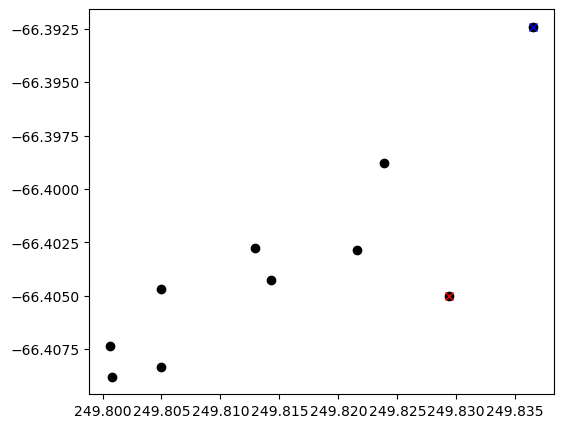

/tmp/ipykernel_1809066/3163857823.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if ((dist_10day_1[ff,ss]/dist_10day_2[ff,ss])>2.5) & \
/tmp/ipykernel_1809066/3163857823.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  if ((dist_10day_1[ff,ss]/dist_10day_2[ff,ss])>2.5) & \


Before correcting for zeros: (74865,)
After correcting for zeros: (71363,)
Min/Max ratio: 1.0 104.48313993444145
Dist. at min ratio: 0.00837479163256887 0.00837479163256887
Dist. at max ratio: 5.465959707409826 0.0523142749235855
Velocity at min ratio in m/s: 9.693045871028786e-06 9.693045871028786e-06
Velocity at max ratio in m/s: 0.006326342253946559 6.0548929309705446e-05


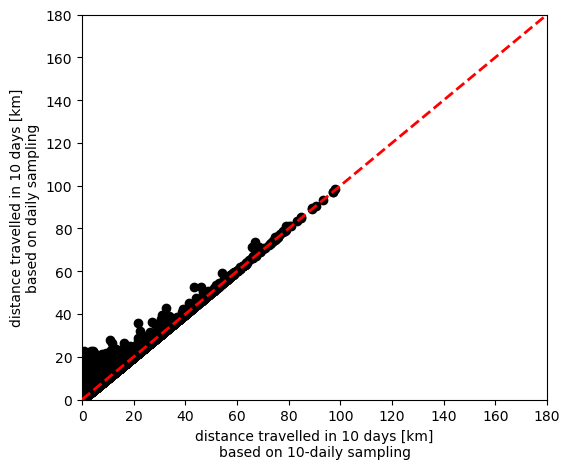

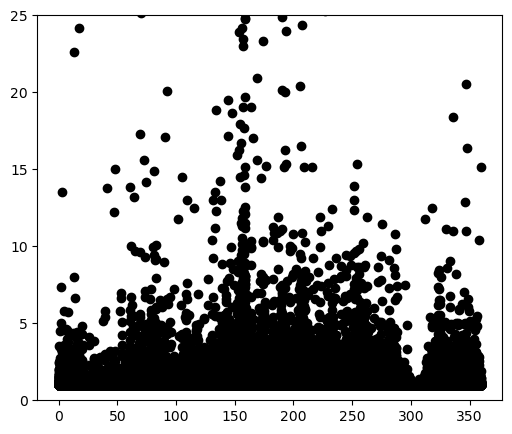

In [12]:
#---
# compare distance travelled for each 10-day period
#---

indSO = np.where(lat_all[0,:]<=-60)[0]
ind_south3060 = np.where((lat_all[0,:]>-60) & (lat_all[0,:]<=-30))[0]
ind_subtropics_S = np.where((lat_all[0,:]>-30) & (lat_all[0,:]<=0))[0]
ind_subtropics_N = np.where((lat_all[0,:]>0) & (lat_all[0,:]<=30))[0]
ind_north3060 = np.where((lat_all[0,:]>30) & (lat_all[0,:]<=60))[0]
ind_north_of_60N = np.where((lat_all[0,:]>60))[0]

#ind_no_SO = np.where(lat_all[0,:]>-60)[0]
#ind_tropics = np.where((lat_all[0,:]>-30) & (lat_all[0,:]<=30))[0]
#ind_south3050 = np.where((lat_all[0,:]>-50) & (lat_all[0,:]<=-30))[0]

dist_all_SO = dist_all[:,indSO]
dist_all_10_SO = dist_all_10[:,indSO]

dist_all_south3060 = dist_all[:,ind_south3060]
dist_all_10_south3060 = dist_all_10[:,ind_south3060]

dist_all_subtropics_S = dist_all[:,ind_subtropics_S]
dist_all_10_subtropics_S = dist_all_10[:,ind_subtropics_S]

dist_all_subtropics_N = dist_all[:,ind_subtropics_N]
dist_all_10_subtropics_N = dist_all_10[:,ind_subtropics_N]

dist_all_north3060 = dist_all[:,ind_north3060]
dist_all_10_north3060 = dist_all_10[:,ind_north3060]

dist_all_north_of_60N = dist_all[:,ind_north_of_60N]
dist_all_10_north_of_60N = dist_all_10[:,ind_north_of_60N]

lon_all_SO = lon_all[:,indSO]
lat_all_SO = lat_all[:,indSO]
lon_all_10_SO = lon_all_10[:,indSO]
lat_all_10_SO = lat_all_10[:,indSO]

lon_all_south3060 = lon_all[:,ind_south3060]
lat_all_south3060 = lat_all[:,ind_south3060]
lon_all_south3060 = lon_all_10[:,ind_south3060]
lat_all_south3060 = lat_all_10[:,ind_south3060]

lon_all_subtropics_S = lon_all[:,ind_subtropics_S]
lat_all_subtropics_S = lat_all[:,ind_subtropics_S]
lon_all_subtropics_S = lon_all_10[:,ind_subtropics_S]
lat_all_subtropics_S = lat_all_10[:,ind_subtropics_S]

lon_all_subtropics_N = lon_all[:,ind_subtropics_N]
lat_all_subtropics_N = lat_all[:,ind_subtropics_N]
lon_all_subtropics_N = lon_all_10[:,ind_subtropics_N]
lat_all_subtropics_N = lat_all_10[:,ind_subtropics_N]

lon_all_north3060 = lon_all[:,ind_north3060]
lat_all_north3060 = lat_all[:,ind_north3060]
lon_all_north3060 = lon_all_10[:,ind_north3060]
lat_all_north3060 = lat_all_10[:,ind_north3060]

lon_all_north_of_60N = lon_all[:,ind_north_of_60N]
lat_all_north_of_60N = lat_all[:,ind_north_of_60N]
lon_all_north_of_60N = lon_all_10[:,ind_north_of_60N]
lat_all_north_of_60N = lat_all_10[:,ind_north_of_60N]

print(dist_all_SO.shape)
print(dist_all_10_SO.shape)

lon_larger_dist = [-1]
lat_larger_dist = [-1]
lon_smaller_dist = [-1]
lat_smaller_dist = [-1]
lon_all2 = [-1]
lat_all2 = [-1]
dist_10day_1  =np.zeros([dist_all_SO.shape[1],217]) # based on daily sampling
dist_10day_2  =np.zeros([dist_all_SO.shape[1],217]) # based on 10-daily sampling
plot_example =True
for ff in range(0,dist_all_SO.shape[1]):
    for ss in range(0,217):
        dist_10day_1[ff,ss] = np.sum(dist_all_SO[ss*10:(ss*10)+9+1,ff])
        dist_10day_2[ff,ss] = dist_all_10_SO[ss,ff]
        
        lon_all2 = np.hstack((lon_all2,lon_all_SO[ss*10,ff]))
        lat_all2 = np.hstack((lat_all2,lat_all_SO[ss*10,ff]))
        
        if ((dist_10day_1[ff,ss]/dist_10day_2[ff,ss])>2.5) & \
                (dist_10day_1[ff,ss]>0) & (dist_10day_2[ff,ss]>0): # distance travelled larger for daily sampling
            lon_larger_dist = np.hstack((lon_larger_dist,lon_all_SO[ss*10,ff]))
            lat_larger_dist = np.hstack((lat_larger_dist,lat_all_SO[ss*10,ff]))
        else:
            if (dist_10day_1[ff,ss]>0) & (dist_10day_2[ff,ss]>0) & (lon_all_SO[ss*10,ff]>0):
                lon_smaller_dist = np.hstack((lon_smaller_dist,lon_all_SO[ss*10,ff]))
                lat_smaller_dist = np.hstack((lat_smaller_dist,lat_all_SO[ss*10,ff]))
             
        if plot_example:
            if ((dist_10day_1[ff,ss]/dist_10day_2[ff,ss])>2.5):
                fig = plt.figure(figsize=(6,5))
                plt.plot(lon_all_SO[ss*10:(ss*10)+9+1,ff],lat_all_SO[ss*10:(ss*10)+9+1,ff],'ko')
                plt.plot(lon_all_SO[(ss*10),ff],lat_all_SO[ss*10,ff],'bx')
                plt.plot(lon_all_SO[(ss*10)+9,ff],lat_all_SO[(ss*10)+9,ff],'rx')
                plt.show()
                plot_example = False
        
        
lon_larger_dist = lon_larger_dist[1:]
lat_larger_dist = lat_larger_dist[1:]
lon_smaller_dist = lon_smaller_dist[1:]
lat_smaller_dist = lat_smaller_dist[1:]
lon_all2 = lon_all2[1:]
lat_all2 = lat_all2[1:]
    
dist_10day_1 = dist_10day_1.ravel()
dist_10day_2 = dist_10day_2.ravel()

# hadnling of zeros: 
print ('Before correcting for zeros:',dist_10day_1.shape)
# kick out zeros
ind = np.where(dist_10day_2>0)[0]
dist_10day_1 = dist_10day_1[ind]
dist_10day_2 = dist_10day_2[ind]
lon_all2 = lon_all2[ind]
lat_all2 = lat_all2[ind]
del ind
ind = np.where(dist_10day_1>0)[0]
dist_10day_1 = dist_10day_1[ind]
dist_10day_2 = dist_10day_2[ind]
lon_all2 = lon_all2[ind]
lat_all2 = lat_all2[ind]
del ind
print ('After correcting for zeros:',dist_10day_1.shape)
            

#print(dist_10day_1)
#print(dist_10day_2)
print('Min/Max ratio:',np.nanmin(dist_10day_1/dist_10day_2),np.nanmax(dist_10day_1/dist_10day_2))
a1 = np.nanargmin(dist_10day_1/dist_10day_2)
a2 = np.nanargmax(dist_10day_1/dist_10day_2)
print('Dist. at min ratio:',dist_10day_1[a1],dist_10day_2[a1])
print('Dist. at max ratio:',dist_10day_1[a2],dist_10day_2[a2])

factor_to_vel = 1000./(10.*24.)/3600. # was: 1000./(120.*24.)/3600. -> I don't understand the "120"
print('Velocity at min ratio in m/s:',factor_to_vel*dist_10day_1[a1],factor_to_vel*dist_10day_2[a1])
print('Velocity at max ratio in m/s:',factor_to_vel*dist_10day_1[a2],factor_to_vel*dist_10day_2[a2])

fig = plt.figure(figsize=(6,5))
plt.plot(dist_10day_2,dist_10day_1,'ko')
#plt.gca().invert_yaxis()
plt.ylabel('distance travelled in 10 days [km]\nbased on daily sampling')
plt.xlabel('distance travelled in 10 days [km]\nbased on 10-daily sampling')
plt.plot([0, 180], [0, 180], color='r', linestyle='--', linewidth=2,zorder=20)
plt.xlim((0,180))
plt.ylim((0,180))
plt.show()

fig = plt.figure(figsize=(6,5))
ind = np.where((dist_10day_1/dist_10day_2)>1)[0]
plt.plot(lon_all2[ind],(dist_10day_1/dist_10day_2)[ind],'ko')
#plt.gca().invert_yaxis()
#plt.ylabel('distance travelled in 10 days [km]\nbased on daily sampling')
#plt.xlabel('distance travelled in 10 days [km]\nbased on 10-daily sampling')
#plt.plot([0, 180], [0, 180], color='r', linestyle='--', linewidth=2,zorder=20)
##plt.xlim((0,180))
plt.ylim((0,25))
plt.show()

#plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)



In [13]:

print(dist_all_SO.shape)
print(dist_all_10_SO.shape)

print(dist_all_south3060.shape)
print(dist_all_10_south3060.shape)

print(dist_all_subtropics_S.shape)
print(dist_all_10_subtropics_S.shape)

print(dist_all_subtropics_N.shape)
print(dist_all_10_subtropics_N.shape)

print(dist_all_north3060.shape)
print(dist_all_10_north3060.shape)

print(dist_all_north_of_60N.shape)
print(dist_all_10_north_of_60N.shape)



(2182, 345)
(218, 345)
(2182, 1172)
(218, 1172)
(2182, 3285)
(218, 3285)
(2182, 3149)
(218, 3149)
(2182, 528)
(218, 528)
(2182, 168)
(218, 168)


In [14]:

cs = 10

counter = 0
counter_stop = 10

threshold = 1.5 #1.25

data1  = np.copy(dist_all_SO)
data10 = np.copy(dist_all_10_SO)

#data1  = np.copy(dist_all_south3060)
#data10 = np.copy(dist_all_10_south3060)

#----
# first, count how many profiles are affected in total
#----
counter_fullfilled = 0
counter_not_fullfilled = 0
for ff in range(0,data1.shape[1]): # loop over floats
    for ss in range(0,210): # loop over profiles
        #d1 = np.sum(dist_all_SO[ss*10:(ss*10)+9+1,ff])
        #d2 = dist_all_10_SO[ss,ff]
        d1 = np.sum(data1[ss*10:(ss*10)+9+1,ff])
        d2 = data10[ss,ff]
        
        if ((d1/d2)>threshold):
            counter_fullfilled = counter_fullfilled+1
        else: 
            #print(d1/d2)
            counter_not_fullfilled = counter_not_fullfilled+1
print('Threshold:',threshold)
print('Condition fullfilled for '+str(counter_fullfilled)+' profiles')
print('Condition NOT fullfilled for '+str(counter_not_fullfilled)+' profiles')
print('% with fullfilled condition: '+str(100*counter_fullfilled/(counter_fullfilled+counter_not_fullfilled))+'%')


#----
plot_example =False
for ff in range(0,dist_all_SO.shape[1]):
    for ss in range(10,12):
        d1 = np.sum(dist_all_SO[ss*10:(ss*10)+9+1,ff])
        d2 = dist_all_10_SO[ss,ff]
             
        if plot_example:
            if ((d1/d2)>threshold):
                
                fig = plt.figure(figsize=(6,5))
                plt.plot(lon_all_SO[ss*10:(ss*10)+9+1,ff],lat_all_SO[ss*10:(ss*10)+9+1,ff],'k',marker='o')
                plt.plot(lon_all_SO[(ss*10),ff],lat_all_SO[ss*10,ff],'bx',markersize=cs)
                plt.plot(lon_all_SO[(ss*10)+9,ff],lat_all_SO[(ss*10)+9,ff],'rx',markersize=cs)
                plt.plot([lon_all_SO[(ss*10),ff],lon_all_SO[(ss*10)+9,ff]],\
                         [lat_all_SO[ss*10,ff],lat_all_SO[(ss*10)+9,ff]],'darkgrey')
                plt.annotate('daily sampling: '+str(np.round(100*d1)/100)+' km',\
                    xy=(0.97,0.92),xycoords='axes fraction',fontsize=10,ha='right',color='k')
                plt.annotate('10-daily sampling: '+str(np.round(100*d2)/100)+' km',\
                    xy=(0.97,0.86),xycoords='axes fraction',fontsize=10,ha='right',color='k')
                plt.ylabel('Latitude in $^{\circ}$N')
                plt.xlabel('Longitude in $^{\circ}$E')
 
                save_plots = False
                if save_plots:
                    dpicnt = 200
                    if counter<10:
                        filename = 'Trajectory_length_10daily_vs_daily_1year_test_SO_only_threshold_'+str(100*threshold)+'_example_0'+str(counter)+'.png'
                    else:
                        filename = 'Trajectory_length_10daily_vs_daily_1year_test_SO_only_threshold_'+str(100*threshold)+'_example_'+str(counter)+'.png'
                    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
                plt.show()
                
                counter = counter+1
                
                if counter == counter_stop:
                    plot_example = False
                
                

/tmp/ipykernel_1809066/2480939252.py:26: RuntimeWarning: invalid value encountered in double_scalars
  if ((d1/d2)>threshold):
/tmp/ipykernel_1809066/2480939252.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  if ((d1/d2)>threshold):


Threshold: 1.5
Condition fullfilled for 7649 profiles
Condition NOT fullfilled for 64801 profiles
% with fullfilled condition: 10.557625948930296%


In [15]:
#---
# FUNCTION
#---

#@njit
def get_statistics_difference_traj_length(num_floats,data_daily,data_10daily,threshold,aux1_full,aux2_full):
    # NOTE: 6 years are currently hard-coded for the overall length of the record!!! 
    #       (217 10-daily periods to assess)
    #
    counter_fullfilled = 0
    counter_not_fullfilled = 0
    counter_all = 0
    for ff in range(0,num_floats): # loop over floats
        for ss in range(0,217): # loop over 10-daily profiles
            d1 = np.sum(data_daily[ss*10:(ss*10)+9+1,ff])
            d2 = data_10daily[ss,ff]
            if (d1>0) & (d2>0):
                if ((d1/d2)>threshold):
                    counter_fullfilled = counter_fullfilled+1
                    aux1_full[counter_all] = d1-d2
                    aux2_full[counter_all] = d1  
                else: 
                    counter_not_fullfilled = counter_not_fullfilled+1
                
            counter_all = counter_all+1
    
    return counter_not_fullfilled,counter_fullfilled,aux1_full,aux2_full
    #return counter_not_fullfilled,np.mean(aux2),np.mean(aux1),np.std(aux1)



In [16]:
#----
# loop over a number of thresholds to determine deviations from 10-day distance
#----
# choose between different regions
#
# to do: use njit to speed this step up
#------

subarea_list = ['south_of_60S','30_60S','0_30S','0_30N','30_60N','north_of_60N']
threshold_list = np.arange(1.01,1.5+0.02,0.02)

perc_with_deviation  = np.nan*np.ones([len(threshold_list),len(subarea_list)])
mean_distance_in_daily_in_km = np.nan*np.ones([len(threshold_list),len(subarea_list)])
mean_deviation_in_km = np.nan*np.ones([len(threshold_list),len(subarea_list)]) # daily minus 10-daily
std_deviation_in_km  = np.nan*np.ones([len(threshold_list),len(subarea_list)])
num_profiles =np.nan*np.ones([len(subarea_list)])
for rr in range(0,len(subarea_list)):
    which_region = subarea_list[rr]
    print(which_region)
    for tt in tqdm(range(0,len(threshold_list))): 
        threshold = threshold_list[tt]
        if which_region in ['south_of_60S']:
            num_floats = dist_all_SO.shape[1]
            data_daily = np.copy(dist_all_SO)
            data_10daily = np.copy(dist_all_10_SO)
        elif which_region in ['30_60S']:
            num_floats = dist_all_south3060.shape[1]
            data_daily = np.copy(dist_all_south3060)
            data_10daily = np.copy(dist_all_10_south3060)
        elif which_region in ['0_30S']:
            num_floats = dist_all_subtropics_S.shape[1]
            data_daily = np.copy(dist_all_subtropics_S)
            data_10daily = np.copy(dist_all_10_subtropics_S)
        elif which_region in ['0_30N']:
            num_floats = dist_all_subtropics_N.shape[1]
            data_daily = np.copy(dist_all_subtropics_N)
            data_10daily = np.copy(dist_all_10_subtropics_N)
        elif which_region in ['30_60N']:
            num_floats = dist_all_north3060.shape[1]
            data_daily = np.copy(dist_all_north3060)
            data_10daily = np.copy(dist_all_10_north3060)
        elif which_region in ['north_of_60N']:
            num_floats = dist_all_north_of_60N.shape[1]
            data_daily = np.copy(dist_all_north_of_60N)
            data_10daily = np.copy(dist_all_10_north_of_60N)
        if tt==0:
            print('Number of floats:',num_floats)
        
        # define arrays to be passed to function
        # numba does not like arrays that grow over time
        # --> pre-define maximal size of array, reduce later
        aux1_full = -999*np.ones([data_10daily.shape[0]*data_10daily.shape[1]])
        aux2_full = -999*np.ones([data_10daily.shape[0]*data_10daily.shape[1]])
        
        counter_not_fullfilled,counter_fullfilled,aux1_full,aux2_full = get_statistics_difference_traj_length(num_floats,\
                                                                                data_daily,\
                                                                    data_10daily,threshold,aux1_full,aux2_full)
        # kick out -999 (everything else was filled)
        aux1_full = aux1_full[aux1_full>-999]
        aux2_full = aux2_full[aux2_full>-999]
        
        perc_with_deviation[tt,rr] = 100*counter_fullfilled/(counter_fullfilled+counter_not_fullfilled)
        mean_distance_in_daily_in_km[tt,rr] = np.mean(aux2_full)
        mean_deviation_in_km[tt,rr] = np.mean(aux1_full)
        std_deviation_in_km[tt,rr] = np.std(aux1_full)
        num_profiles[rr] = counter_fullfilled+counter_not_fullfilled
        
        del data_daily,data_10daily
        #del aux1_full,aux2_full,counter_not_fullfilled
        
print('done')
#print(num_profiles,' in total')


south_of_60S


  0%|          | 0/26 [00:00<?, ?it/s]

Number of floats: 345


100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


30_60S


  0%|          | 0/26 [00:00<?, ?it/s]

Number of floats: 1172


100%|██████████| 26/26 [00:24<00:00,  1.06it/s]


0_30S


  0%|          | 0/26 [00:00<?, ?it/s]

Number of floats: 3285


100%|██████████| 26/26 [01:05<00:00,  2.54s/it]


0_30N


  0%|          | 0/26 [00:00<?, ?it/s]

Number of floats: 3149


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]


30_60N


  0%|          | 0/26 [00:00<?, ?it/s]

Number of floats: 528


100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


north_of_60N


  4%|▍         | 1/26 [00:00<00:03,  7.23it/s]

Number of floats: 168


100%|██████████| 26/26 [00:03<00:00,  7.28it/s]

done


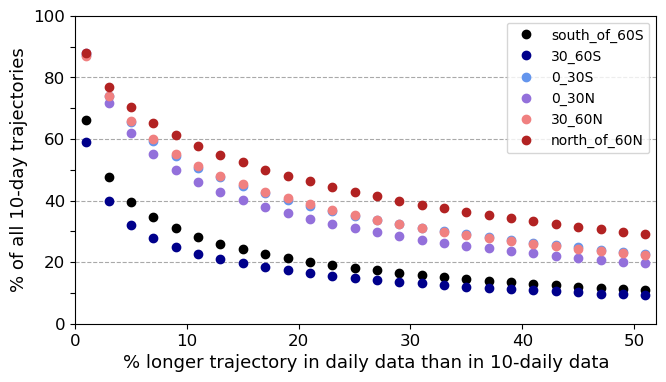

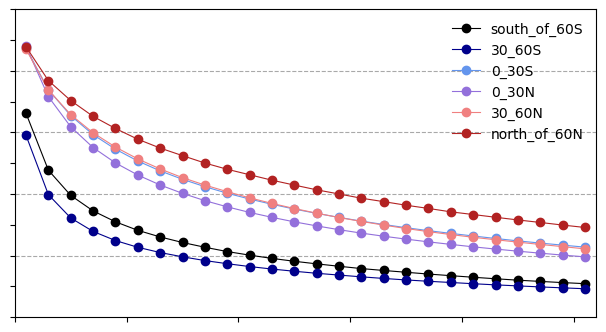

In [17]:
#---
# plot
#---
save_plots = False

thresholds_perc = [100*(x-1) for x in threshold_list]
xlim1,xlim2 = 0,np.max(thresholds_perc)+1
lw = 0.8
ls = '--'
ls2 = '-'
lw2 = 0.8
fs = 12

color1 = 'black' 
color2 = 'darkblue' 
color3 = 'cornflowerblue' 
color4 = 'mediumpurple'
color5 = 'lightcoral'
color6 = 'firebrick' 

#subarea_list = ['south_of_60S','30_60S','0_30S','0_30N','30_60N','north_of_60N']

fig = plt.figure(figsize=(7.5,4))
plt.hlines(20,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(40,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(60,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(80,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.plot(thresholds_perc,perc_with_deviation[:,0],linewidth=0,color=color1,marker='o',label=subarea_list[0])
plt.plot(thresholds_perc,perc_with_deviation[:,1],linewidth=0,color=color2,marker='o',label=subarea_list[1])
plt.plot(thresholds_perc,perc_with_deviation[:,2],linewidth=0,color=color3,marker='o',label=subarea_list[2])
plt.plot(thresholds_perc,perc_with_deviation[:,3],linewidth=0,color=color4,marker='o',label=subarea_list[3])
plt.plot(thresholds_perc,perc_with_deviation[:,4],linewidth=0,color=color5,marker='o',label=subarea_list[4])
plt.plot(thresholds_perc,perc_with_deviation[:,5],linewidth=0,color=color6,marker='o',label=subarea_list[5])
plt.xlim((xlim1,xlim2)) 
plt.ylim((0,100))
plt.xlabel('% longer trajectory in daily data than in 10-daily data',fontsize=fs+1)
plt.ylabel('% of all 10-day trajectories',fontsize=fs+1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[0,'',20,'',40,'',60,'',80,'',100],fontsize=fs)
plt.xticks(fontsize=fs)
plt.legend()
#plt.annotate('mean$\pm$std of deviation in km: '+str()+''+str(),\
#            xy=(0.99,1.02),xycoords='axes fraction',fontsize=10,ha='right',color='k',fontweight='bold')

if save_plots:
    dpicnt = 200
    filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_all_regions.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()

plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(7.5,4))
    plt.hlines(20,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(40,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(60,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(80,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.plot(thresholds_perc,perc_with_deviation[:,0],linewidth=lw2,color=color1,marker='o',linestyle=ls2,label=subarea_list[0])
    plt.plot(thresholds_perc,perc_with_deviation[:,1],linewidth=lw2,color=color2,marker='o',linestyle=ls2,label=subarea_list[1])
    plt.plot(thresholds_perc,perc_with_deviation[:,2],linewidth=lw2,color=color3,marker='o',linestyle=ls2,label=subarea_list[2])
    plt.plot(thresholds_perc,perc_with_deviation[:,3],linewidth=lw2,color=color4,marker='o',linestyle=ls2,label=subarea_list[3])
    plt.plot(thresholds_perc,perc_with_deviation[:,4],linewidth=lw2,color=color5,marker='o',linestyle=ls2,label=subarea_list[4])
    plt.plot(thresholds_perc,perc_with_deviation[:,5],linewidth=lw2,color=color6,marker='o',linestyle=ls2,label=subarea_list[5])
    plt.xlim((xlim1,xlim2)) 
    plt.ylim((0,100))
    #plt.xlabel('% longer trajectory in daily data than in 10-daily data',fontsize=fs+1)
    #plt.ylabel('% of all 10-day trajectories',fontsize=fs+1)
    plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[],fontsize=fs)
    plt.xticks([0,10,20,30,40,50],[],fontsize=fs)
    plt.legend(frameon=False)
    #plt.annotate('mean$\pm$std of deviation in km: '+str()+''+str(),\
    #            xy=(0.99,1.02),xycoords='axes fraction',fontsize=10,ha='right',color='k',fontweight='bold')

    if save_plots:
        dpicnt = 200
        filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_all_regions.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()




In [18]:
#print(perc_with_deviation2)
#print(num_profiles2.shape)

vel_all    = 100*1000*(dist_all/(1*24))/3600 # convert from distance in km (per 1-day period) to velocity in cm s-1
vel_all_10 = 100*1000*(dist_all_10/(10*24))/3600 # convert from distance in km (per 10-day period) to velocity in cm s-1

vel_all[vel_all==0]=np.nan
vel_all_10[vel_all_10==0]=np.nan



ind_not_nan = np.where(~np.isnan(vel_all_10.ravel()))[0]
print(np.quantile(vel_all_10.ravel()[ind_not_nan],0.1))
print(np.quantile(vel_all_10.ravel()[ind_not_nan],0.3))
print(np.quantile(vel_all_10.ravel()[ind_not_nan],0.5))
print(np.quantile(vel_all_10.ravel()[ind_not_nan],0.7))
print(np.quantile(vel_all_10.ravel()[ind_not_nan],0.9))




0.152428276308042
0.3857289324604851
0.709315731790439
1.285772219157858
2.923493781545178


In [19]:
#---
# FUNCTION
#---

@njit
def get_statistics_difference_traj_length_2(num_floats,data_daily,data_10daily,threshold,aux1_full,aux2_full):
    # NOTE: 6 years are currently hard-coded for the overall length of the record!!! 
    #       (217 10-daily periods to assess)
    #
    counter_fullfilled = 0
    counter_not_fullfilled = 0
    counter_all = 0
    for ff in range(0,num_floats): # loop over floats
        for ss in range(0,217): # loop over 10-daily profiles
            d1 = np.sum(data_daily[ss*10:(ss*10)+9+1,ff]) 
            d2 = data_10daily[ss,ff]
            #print(d1,d2)
            if (d1>0) & (d2>0):
                if ((d1/d2)>threshold):
                    counter_fullfilled = counter_fullfilled+1
                    aux1_full[counter_all] = d1-d2
                    aux2_full[counter_all] = d1  
                else: 
                    counter_not_fullfilled = counter_not_fullfilled+1
                
            counter_all = counter_all+1
    
    return counter_not_fullfilled,counter_fullfilled,aux1_full,aux2_full
    #return counter_not_fullfilled,np.mean(aux2),np.mean(aux1),np.std(aux1)



In [20]:
#----
# loop over a number of thresholds to determine deviations from 10-day distance
#
# instead of doing this for different regions, do it for different velocity bins! 
#
# to do: use njit to speed this step up
#------

ind_not_nan = np.where(~np.isnan(vel_all_10.ravel()))[0]
velocity_list  = [np.quantile(vel_all_10.ravel()[ind_not_nan],0.2),\
            np.quantile(vel_all_10.ravel()[ind_not_nan],0.4),\
            np.quantile(vel_all_10.ravel()[ind_not_nan],0.6),\
            np.quantile(vel_all_10.ravel()[ind_not_nan],0.8),\
            np.quantile(vel_all_10.ravel()[ind_not_nan],0.99999)]
#velocity_list  = np.arange(0.01,10+0.25,0.25)

threshold_list = np.arange(1.01,1.5+0.02,0.02)

vel_all    = 100*1000*(dist_all_north_of_60N/(1*24))/3600 # convert from distance in km (per 1-day period) to velocity in cm s-1
vel_all_10 = 100*1000*(dist_all_10_north_of_60N/(10*24))/3600 # convert from distance in km (per 10-day period) to velocity in cm s-1

#vel_all    = 100*1000*(dist_all/(1*24))/3600 # convert from distance in km (per 1-day period) to velocity in cm s-1
#vel_all_10 = 100*1000*(dist_all_10/(10*24))/3600 # convert from distance in km (per 10-day period) to velocity in cm s-1


#vel_all[vel_all==0]=np.nan
#vel_all_10[vel_all_10==0]=np.nan

perc_with_deviation2  = np.nan*np.ones([len(threshold_list),len(velocity_list)])
mean_distance_in_daily_in_km2 = np.nan*np.ones([len(threshold_list),len(velocity_list)])
mean_deviation_in_km2 = np.nan*np.ones([len(threshold_list),len(velocity_list)]) # daily minus 10-daily
std_deviation_in_km2  = np.nan*np.ones([len(threshold_list),len(velocity_list)])
num_profiles2 =np.nan*np.ones([len(velocity_list)])
for rr in tqdm(range(0,len(velocity_list)-1)):
    aux_vel = velocity_list[rr]
    
    # how many trajectoies fall into current velocity bin?
    #ind = np.where((vel_all_10 > velocity_list[rr]) & (vel_all_10 <= velocity_list[rr+1]))[0]
    ind = np.where((vel_all > velocity_list[rr]) & (vel_all <= velocity_list[rr+1]))[0]
    
    #---
    # set trajectories outside of the current bin to NaN
    #---
    # data_daily = np.copy(dist_all_north_of_60N)
    #        data_10daily = np.copy(dist_all_10_north_of_60N)
    
    # daily
    dist2 = np.copy(dist_all_north_of_60N)
    #dist2 = np.copy(dist_all)
 #   dist2[np.isnan(vel_all)]=np.nan
    dist2[(vel_all < velocity_list[rr]) | (vel_all >= velocity_list[rr+1])] = np.nan
    # 10-daily
    dist_10_2 = np.copy(dist_all_10_north_of_60N)
    #dist_10_2 = np.copy(dist_all_10)
 #   dist_10_2[np.isnan(vel_all_10)]=np.nan
    dist_10_2[(vel_all_10 < velocity_list[rr]) | (vel_all_10 >= velocity_list[rr+1])] = np.nan
    #print('All inside of current bin, daily:',np.where(~np.isnan(dist2))[0].shape[0])
    #print('All inside of current bin, 10-daily:',np.where(~np.isnan(dist_10_2))[0].shape[0])
    
    #
    dist2[np.isnan(dist2)] = -999
    dist_10_2[np.isnan(dist_10_2)] = -999
    
    #print(aux_vel)
    # daily
    #print('all entries:',dist2.ravel().shape[0])
    #print('Numbers should be the same:',np.where(~np.isnan(dist2))[0].shape[0],ind.shape[0])
    #print('All outside of current bin:',np.where(np.isnan(dist2))[0].shape[0])
    #print(np.where(~np.isnan(dist2))[0].shape[0]+np.where(np.isnan(dist2))[0].shape[0])
    # 10-daily
    #print('all entries:',dist_10_2.ravel().shape[0])
    #print('Numbers should be the same:',np.where(~np.isnan(dist_10_2))[0].shape[0],ind.shape[0])
    #print('All outside of current bin:',np.where(np.isnan(dist_10_2))[0].shape[0])
    #print(np.where(~np.isnan(dist_10_2))[0].shape[0]+np.where(np.isnan(dist_10_2))[0].shape[0])
    
    num_floats = dist2.shape[1]
    
    for tt in range(0,len(threshold_list)): 
        threshold = threshold_list[tt]
                
        # define arrays to be passed to function
        # numba does not like arrays that grow over time
        # --> pre-define maximal size of array, reduce later
        aux1_full = -999*np.ones([dist_10_2.shape[0]*dist_10_2.shape[1]])
        aux2_full = -999*np.ones([dist_10_2.shape[0]*dist_10_2.shape[1]])
        
        counter_not_fullfilled,counter_fullfilled,aux1_full,aux2_full = get_statistics_difference_traj_length_2(num_floats,\
                                                                                dist2,\
                                                                    dist_10_2,threshold,aux1_full,aux2_full)
        # kick out -999 (everything else was filled)
        aux1_full = aux1_full[aux1_full>-999]
        aux2_full = aux2_full[aux2_full>-999]
        
        if len(aux1_full)>0:
            perc_with_deviation2[tt,rr] = 100*counter_fullfilled/(counter_fullfilled+counter_not_fullfilled)
            mean_distance_in_daily_in_km2[tt,rr] = np.mean(aux2_full)
            mean_deviation_in_km2[tt,rr] = np.mean(aux1_full)
            std_deviation_in_km2[tt,rr] = np.std(aux1_full)
            num_profiles2[rr] = counter_fullfilled+counter_not_fullfilled
        
        del aux1_full,aux2_full,counter_not_fullfilled,counter_fullfilled
        
    del dist_10_2,dist2
    
print('done')


100%|██████████| 4/4 [00:00<00:00, 11.21it/s]

done


In [21]:
print(perc_with_deviation2.shape)
print(perc_with_deviation2[:,3])
#print(perc_with_deviation[:,4])
print(velocity_list)
print(num_profiles2)

(26, 5)
[11.70568562  2.67558528  1.33779264  1.33779264  1.00334448  0.33444816
  0.33444816  0.33444816         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]
[0.26431400445193604, 0.5297679685594816, 0.9452211509707332, 1.8384360305877998, 30.84338840421773]
[296. 194. 197. 299.  nan]


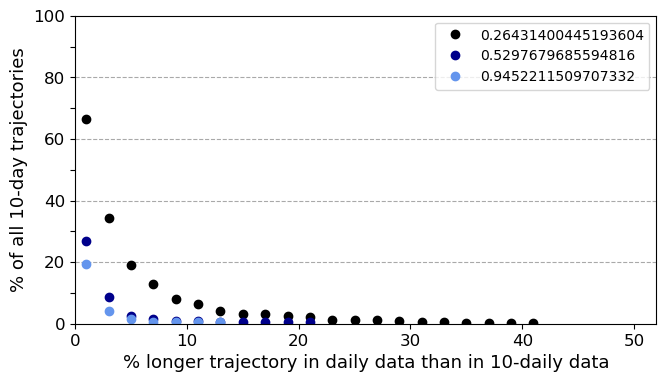

In [22]:
#---
# plot
#---
save_plots = False

thresholds_perc = [100*(x-1) for x in threshold_list]
xlim1,xlim2 = 0,np.max(thresholds_perc)+1
lw = 0.8
ls = '--'
ls2 = '-'
lw2 = 0.8
fs = 12

color1 = 'black' 
color2 = 'darkblue' 
color3 = 'cornflowerblue' 
color4 = 'mediumpurple'
color5 = 'lightcoral'
color6 = 'firebrick' 

#subarea_list = ['south_of_60S','30_60S','0_30S','0_30N','30_60N','north_of_60N']

fig = plt.figure(figsize=(7.5,4))
plt.hlines(20,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(40,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(60,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(80,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.plot(thresholds_perc,perc_with_deviation2[:,0],linewidth=0,color=color1,marker='o',label=velocity_list[0])
plt.plot(thresholds_perc,perc_with_deviation2[:,1],linewidth=0,color=color2,marker='o',label=velocity_list[1])
plt.plot(thresholds_perc,perc_with_deviation2[:,2],linewidth=0,color=color3,marker='o',label=velocity_list[2])
#plt.plot(thresholds_perc,perc_with_deviation2[:,3],linewidth=0,color=color4,marker='o',label=velocity_list[3])
plt.xlim((xlim1,xlim2)) 
plt.ylim((0,100))
plt.xlabel('% longer trajectory in daily data than in 10-daily data',fontsize=fs+1)
plt.ylabel('% of all 10-day trajectories',fontsize=fs+1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[0,'',20,'',40,'',60,'',80,'',100],fontsize=fs)
plt.xticks(fontsize=fs)
plt.legend()
#plt.annotate('mean$\pm$std of deviation in km: '+str()+''+str(),\
#            xy=(0.99,1.02),xycoords='axes fraction',fontsize=10,ha='right',color='k',fontweight='bold')

if save_plots:
    dpicnt = 200
    filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_velocity_bins.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()

plot_eps = False
if plot_eps:
    fig = plt.figure(figsize=(7.5,4))
    plt.hlines(20,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(40,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(60,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(80,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.plot(thresholds_perc,perc_with_deviation[:,0],linewidth=lw2,color=color1,marker='o',linestyle=ls2,label=subarea_list[0])
    plt.plot(thresholds_perc,perc_with_deviation[:,1],linewidth=lw2,color=color2,marker='o',linestyle=ls2,label=subarea_list[1])
    plt.plot(thresholds_perc,perc_with_deviation[:,2],linewidth=lw2,color=color3,marker='o',linestyle=ls2,label=subarea_list[2])
    plt.plot(thresholds_perc,perc_with_deviation[:,3],linewidth=lw2,color=color4,marker='o',linestyle=ls2,label=subarea_list[3])
    plt.plot(thresholds_perc,perc_with_deviation[:,4],linewidth=lw2,color=color5,marker='o',linestyle=ls2,label=subarea_list[4])
    plt.plot(thresholds_perc,perc_with_deviation[:,5],linewidth=lw2,color=color6,marker='o',linestyle=ls2,label=subarea_list[5])
    plt.xlim((xlim1,xlim2)) 
    plt.ylim((0,100))
    #plt.xlabel('% longer trajectory in daily data than in 10-daily data',fontsize=fs+1)
    #plt.ylabel('% of all 10-day trajectories',fontsize=fs+1)
    plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[],fontsize=fs)
    plt.xticks([0,10,20,30,40,50],[],fontsize=fs)
    plt.legend(frameon=False)
    #plt.annotate('mean$\pm$std of deviation in km: '+str()+''+str(),\
    #            xy=(0.99,1.02),xycoords='axes fraction',fontsize=10,ha='right',color='k',fontweight='bold')

    if save_plots:
        dpicnt = 200
        filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_velocity_bins.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()


In [23]:
#----
# for each velocity bin, how large is the average difference in the trajectory length?
#------

ind_not_nan = np.where(~np.isnan(vel_all_10.ravel()))[0]
#velocity_list  = [np.quantile(vel_all_10.ravel()[ind_not_nan],0.2),\
#            np.quantile(vel_all_10.ravel()[ind_not_nan],0.4),\
#            np.quantile(vel_all_10.ravel()[ind_not_nan],0.6),\
#            np.quantile(vel_all_10.ravel()[ind_not_nan],0.8),\
#            np.quantile(vel_all_10.ravel()[ind_not_nan],0.99999)]
velocity_list  = np.arange(0.0,5+0.2,0.2)

threshold_list = np.arange(1.01,1.5+0.02,0.02)

vel_all    = 100*1000*(dist_all/(1*24))/3600 # convert from distance in km (per 1-day period) to velocity in cm s-1
vel_all_10 = 100*1000*(dist_all_10/(10*24))/3600 # convert from distance in km (per 10-day period) to velocity in cm s-1

#vel_all    = 100*1000*(dist_all/(1*24))/3600 # convert from distance in km (per 1-day period) to velocity in cm s-1
#vel_all_10 = 100*1000*(dist_all_10/(10*24))/3600 # convert from distance in km (per 10-day period) to velocity in cm s-1

#vel_all[vel_all==0]=np.nan
#vel_all_10[vel_all_10==0]=np.nan

#---
# FUNCTION
#---

@njit
def get_statistics_difference_traj_length_3(num_floats,data_daily,data_10daily,aux1_full,aux2_full,aux3_full):
    # NOTE: 6 years are currently hard-coded for the overall length of the record!!! 
    #       (217 10-daily periods to assess)
    #
    counter_fullfilled = 0
    counter_not_fullfilled = 0
    counter_all = 0
    for ff in range(0,num_floats): # loop over floats
        for ss in range(0,217): # loop over 10-daily profiles
            d1 = np.sum(data_daily[ss*10:(ss*10)+9+1,ff])
            d2 = data_10daily[ss,ff]
            #print(d1,d2)
            #print(d1,d2)
            if ~np.isnan(d2):
                if (d1>0) & (d2>0):
                    #print(d1/d2)
                    aux1_full[counter_all] = d1-d2
                    aux2_full[counter_all] = d1  
                    aux3_full[counter_all] = d2  
            counter_all = counter_all+1
                    
    return aux1_full,aux2_full,aux3_full
    #return counter_not_fullfilled,np.mean(aux2),np.mean(aux1),np.std(aux1)

mean_distance_in_daily_in_km3 = np.nan*np.ones([len(velocity_list),3])
mean_distance_in_10daily_in_km3 = np.nan*np.ones([len(velocity_list),3])
mean_deviation_in_km3 = np.nan*np.ones([len(velocity_list),3]) # daily minus 10-daily
std_deviation_in_km3  = np.nan*np.ones([len(velocity_list)])
num_in_bin = np.zeros(len(velocity_list))
for rr in tqdm(range(0,len(velocity_list)-1)): #range(89,90)
    aux_vel = velocity_list[rr]
    
    # how many trajectoies fall into current velocity bin?
    #ind = np.where((vel_all_10 > velocity_list[rr]) & (vel_all_10 <= velocity_list[rr+1]))[0]
    ind = np.where((vel_all > velocity_list[rr]) & (vel_all <= velocity_list[rr+1]))[0]
    num_in_bin[rr] = ind.shape[0]
    
    #---
    # set trajectories outside of the current bin to NaN
    #---
     
    # careful when selecting data for current velocity bin
    # example: in daily data, it could happen that day 5 within any 10-day period is inside the bin, while day 6-8 are outside
    # this leads to very few full 10-day periods in daily data that are filled for a given bin
    # -> only filter based on 10-day period
    
    # daily
    dist2 = np.copy(dist_all)
   # dist2[(vel_all < velocity_list[rr]) | (vel_all >= velocity_list[rr+1])] = np.nan
    # 10-daily
    dist_10_2 = np.copy(dist_all_10)
    dist_10_2[(vel_all_10 < velocity_list[rr]) | (vel_all_10 >= velocity_list[rr+1])] = np.nan
    #print('All inside of current bin, daily:',np.where(~np.isnan(dist2))[0].shape[0])
    #print('All inside of current bin, 10-daily:',np.where(~np.isnan(dist_10_2))[0].shape[0])
    
    #
    dist2[np.isnan(dist2)] = -999
    dist_10_2[np.isnan(dist_10_2)] = -999
    
    #print(aux_vel)
    # daily
    #print('all entries:',dist2.ravel().shape[0])
    #print('Numbers should be the same:',np.where(~np.isnan(dist2))[0].shape[0],ind.shape[0])
    #print('All outside of current bin:',np.where(np.isnan(dist2))[0].shape[0])
    #print(np.where(~np.isnan(dist2))[0].shape[0]+np.where(np.isnan(dist2))[0].shape[0])
    # 10-daily
    #print('all entries:',dist_10_2.ravel().shape[0])
    #print('Numbers should be the same:',np.where(~np.isnan(dist_10_2))[0].shape[0],ind.shape[0])
    #print('All outside of current bin:',np.where(np.isnan(dist_10_2))[0].shape[0])
    #print(np.where(~np.isnan(dist_10_2))[0].shape[0]+np.where(np.isnan(dist_10_2))[0].shape[0])
    
    num_floats = dist2.shape[1]
    
    # define arrays to be passed to function
    # numba does not like arrays that grow over time
    # --> pre-define maximal size of array, reduce later
    aux1_full = -999*np.ones([dist_10_2.shape[0]*dist_10_2.shape[1]])
    aux2_full = -999*np.ones([dist_10_2.shape[0]*dist_10_2.shape[1]])
    aux3_full = -999*np.ones([dist_10_2.shape[0]*dist_10_2.shape[1]])
        
    aux1_full,aux2_full,aux3_full = get_statistics_difference_traj_length_3(num_floats,\
                                                                                dist2,\
                                                                    dist_10_2,aux1_full,aux2_full,aux3_full)
    # kick out -999 (everything else was filled)
    aux1_full = aux1_full[aux1_full>-999]
    aux2_full = aux2_full[aux2_full>-999]
    aux3_full = aux3_full[aux3_full>-999]
    aux1_full = aux1_full[~np.isnan(aux1_full)]
    aux2_full = aux2_full[~np.isnan(aux2_full)]
    aux3_full = aux3_full[~np.isnan(aux3_full)]
        
    if len(aux1_full)>0:
        perc1 = 0.1
        perc2 = 0.9
        #perc1 = 0.25
        #perc2 = 0.75
        mean_distance_in_daily_in_km3[rr,0] = np.quantile(aux2_full,perc1)
        mean_distance_in_daily_in_km3[rr,1] = np.median(aux2_full)
        mean_distance_in_daily_in_km3[rr,2] = np.quantile(aux2_full,perc2)
        mean_distance_in_10daily_in_km3[rr,0] = np.quantile(aux3_full,perc1)
        mean_distance_in_10daily_in_km3[rr,1] = np.median(aux3_full)
        mean_distance_in_10daily_in_km3[rr,2] = np.quantile(aux3_full,perc2)
        
        mean_deviation_in_km3[rr,0] = np.quantile(aux1_full,0.25)
        mean_deviation_in_km3[rr,1] = np.median(aux1_full)
        mean_deviation_in_km3[rr,2] = np.quantile(aux1_full,0.75)
        std_deviation_in_km3[rr] = np.std(aux1_full)
    
    del aux1_full,aux2_full
        
    del dist_10_2,dist2

print(num_in_bin)

print('done')


100%|██████████| 25/25 [00:06<00:00,  4.10it/s]

[1830768. 2686084. 2333942. 1843945. 1449626. 1147692.  921635.  755264.
  629221.  533778.  456243.  397467.  350486.  312066.  280193.  249928.
  222677.  197917.  176299.  155596.  138883.  122433.  108559.   95374.
   83524.       0.]
done


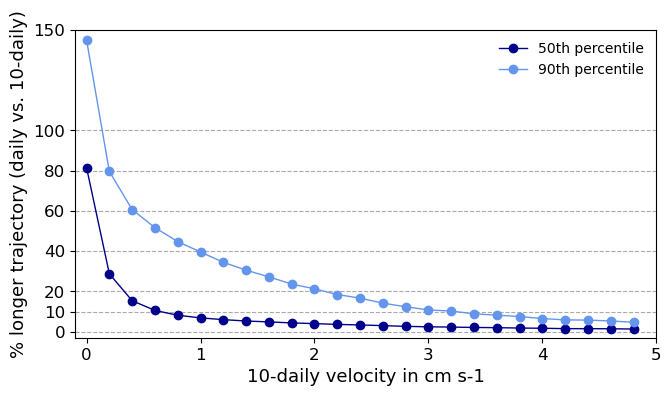

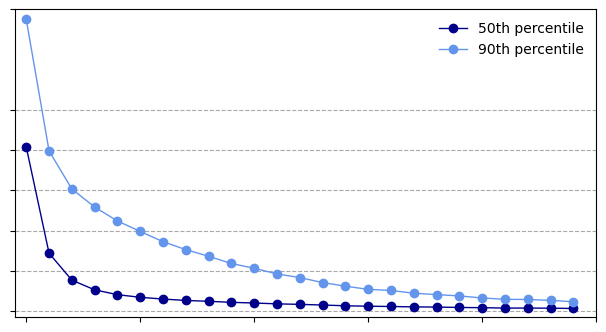

In [24]:
#---
# plot: 
#---
save_plots = True

thresholds_perc = [100*(x-1) for x in threshold_list]
xlim1,xlim2 = velocity_list[0]-0.1,velocity_list[-1]
lw = 0.8
ls = '--'
ls2 = '-'
lw2 = 0.8
fs = 12

color1 = 'black' 
color2 = 'darkblue' 
color3 = 'cornflowerblue' 
color4 = 'mediumpurple'
color5 = 'lightcoral'
color6 = 'firebrick' 


# to plot: % difference in daily relative to 10-daily

# mean_deviation: daily minus 10-daily
# 10-daily: -1*(mean_deviation_in_km3[:,1] - mean_distance_in_daily_in_km3[:,1])
#mean_distance_in_daily_in_km3/(-1*(mean_deviation_in_km3 - mean_distance_in_daily_in_km3)) -> this resulted in different percentage
# make sure to calculate the difference in the same way across plots!

deviation = mean_distance_in_daily_in_km3/mean_distance_in_10daily_in_km3

#---
# png
#---
fig = plt.figure(figsize=(7.5,4))
plt.hlines(1,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(1.1,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(1.2,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(1.4,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(1.6,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(1.8,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
plt.hlines(2,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)

#plt.plot(velocity_list,deviation[:,0],linewidth=1,color=color1,marker='o')
plt.plot(velocity_list,deviation[:,1],linewidth=1,color=color2,marker='o',label='50th percentile')
plt.plot(velocity_list,deviation[:,2],linewidth=1,color=color3,marker='o',label=str(int(100*perc2))+'th percentile')

plt.ylabel('% longer trajectory (daily vs. 10-daily)',fontsize=fs+1)
plt.xlabel('10-daily velocity in cm s-1',fontsize=fs+1)
plt.xticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=fs)
plt.yticks([1.0,1.1,1.2,1.4,1.6,1.8,2.0,2.5],[0,10,20,40,60,80,100,150],fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim((0.97,2.5))
plt.xlim((xlim1,xlim2))
plt.legend(frameon=False)

if save_plots:
    dpicnt = 200
    filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_vs_velocity.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()

#--------------
#----
# how do these new plots fit with earlier plot based on regions?
#----
# why do I never get discrepancies larger than a few percent??
# SOLVED: the problem was how I calculated the deviation in %! -> I only computed the ratio between the two in the subarea plot!
#----
# new problem: why are so few velocity bins filled? CHECK for NaNs!!!!
# SOLVED: the problem was that I corrected both daily and 10-daily data to only include data in current velocity bin
#         as a result, there was very few occassions fo which all 10 days were filled in daily data -> with -999 as the fill value, 
#         this resulted in very few available data points for comparison
#--------------

#---
# eps
#---
plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(7.5,4))
    plt.hlines(1,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(1.2,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(1.4,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(1.6,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(1.8,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)
    plt.hlines(2,xlim1,xlim2,color='darkgrey',linewidth=lw,linestyle=ls,zorder=0)

    #plt.plot(velocity_list,deviation[:,0],linewidth=1,color=color1,marker='o')
    plt.plot(velocity_list,deviation[:,1],linewidth=1,color=color2,marker='o',label='50th percentile')
    plt.plot(velocity_list,deviation[:,2],linewidth=1,color=color3,marker='o',label=str(int(100*perc2))+'th percentile')

    #plt.ylabel('% longer trajectory (daily vs. 10-daily)',fontsize=fs+1)
    #plt.xlabel('10-daily velocity in cm s-1',fontsize=fs+1)
    plt.xticks([0,1,2,3,4,5],[],fontsize=fs)
    plt.yticks([1.0,1.2,1.4,1.6,1.8,2.0,2.5],[],fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.ylim((0.97,2.5))
    plt.xlim((xlim1,xlim2))
    plt.legend(frameon=False)

    if save_plots:
        dpicnt = 200
        filename = 'FOR_PAPER_Trajectory_length_10daily_vs_daily_6year_run_vs_velocity.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()


In [25]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/trajectory_daily_vs_10daily/6year_run/
